<a href="https://colab.research.google.com/github/Alulestad/Alulestad/blob/main/docs/vision/neural/vit/code/vit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modelo de clasificación de imágenes usando ViT
==============================================

## Introducción

Los modelos basados en transformers para visión han demostrado ser ampliamente potentes en régimenes donde la cantidad de datos es suficiente, a pesar de no tener sezgo inductivo presente en su arquitectura.

En este ejemplo veremos cómo podemos utilizar un modelo de este tipo para resolver un problema de clasificación de imágenes.

### Preparación del ambiente

Intalamos las librerias necesarias

In [1]:
!pip install -q transformers datasets --quiet

In [2]:
!pip install datasets

In [3]:
!pip install --upgrade datasets

### Sobre el conjunto de datos de este ejemplo

Para ejemplificar esta técnica utilizaremos un conjunto de datos muy popular llamado CIFAR-10. CIFAR-10 es un conjunto de datos que consiste en 60.000 imagenes a color de 32x32 agrupadas en 10 clases, con 6000 imagenes cada una. Hay alrededor de 50000 imagenes para entrenamiento y 10000 para testing.

Las categorias son:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Podemos cargar este conjunto de datos facilmente utilizando `datasets`:

In [4]:
from datasets import load_dataset

# Cargar el conjunto de datos CIFAR-10
dataset = load_dataset("cifar10")

# Ver el conjunto de entrenamiento y prueba
train_ds = dataset["train"]
test_ds = dataset["test"]

# Imprimir las primeras muestras de los datos
print(train_ds[0])
print(test_ds[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7A1DB001C350>, 'label': 0}
{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7A1DA3F42ED0>, 'label': 3}


Divieremos el conjunto de datos de entrenamiento en 2 subconjuntos: uno de entrenamiento (90%) y otro de validación (10%):

In [5]:
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

Veamos algunos detalles del conjunto de datos:

In [6]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 45000
})

In [7]:
train_ds.features

{'img': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

Veamos algunos ejemplos:

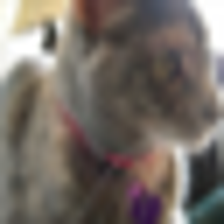

In [8]:
train_ds[0]['img'].resize((224, 224))

## Construcción de un modelo de clasificación utilizando ViT

Antes de comenzar necesitaremos verificar que tenemos el runtime correcto en nuestro ambiente. Esta tarea se beneficiará mucho de una GPU.

In [9]:
import torch
print("GPUs disponibles: ", torch.cuda.device_count())

GPUs disponibles:  1


In [10]:
model_name = "google/vit-base-patch16-224-in21k"

### Preprocesamiento

Como es común, deberemos de ocuparnos del preprocesamiento de nuestras imágenes:

#### Labels

Debemos de disponer de un mapeo entre las etiquetas y sus valores:

    

In [11]:
label2id = { label:id for id, label in enumerate(test_ds.features["label"].names) }
id2label = { id:label for id, label in enumerate(test_ds.features["label"].names) }

#### Tamaño y cantidad de parches

Los transformers esperan recibir cada imagen con una resolución específica y una cantidad de parches particular. Esta tarea se puede realizar utilizando el concepto de `processor` en `transformers`.

Este tipo de components preprocesan los datos antes de ser enviados al modelo que los procesará. En este caso, utilizaremos el `processor` associado con un modelo en particular, `google/vit-base-patch16-224-in21k`. Notar como en el nombre está codificado el tamaño de los parches (16x16) y la resolución de las imágenes (224x224).

In [12]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained(model_name)

Este componente también realizará normalización y estandarización, dos operaciones que típicamente realizamos en visión por computadora.

Generaremos una función que toma un ejemplo del conjunto de datos y aplica nuestro `processor` de forma que devuelve los pixeles preprocesados y su etiqueta correspondiente:

In [13]:
def process_example(example):
    inputs = processor(example['img'], return_tensors='pt')
    inputs['labels'] = example['label']

    return inputs

Veamos como funciona la función con un ejemplo:

In [14]:
example = process_example(train_ds[0])
example

{'pixel_values': tensor([[[[ 0.9373,  0.9373,  0.9373,  ...,  0.9843,  0.9843,  0.9843],
          [ 0.9373,  0.9373,  0.9373,  ...,  0.9843,  0.9843,  0.9843],
          [ 0.9373,  0.9373,  0.9373,  ...,  0.9843,  0.9843,  0.9843],
          ...,
          [-0.1059, -0.1059, -0.1059,  ..., -0.7725, -0.7725, -0.7725],
          [-0.1059, -0.1059, -0.1059,  ..., -0.7725, -0.7725, -0.7725],
          [-0.1059, -0.1059, -0.1059,  ..., -0.7725, -0.7725, -0.7725]],

         [[ 0.9294,  0.9294,  0.9294,  ...,  0.9843,  0.9843,  0.9843],
          [ 0.9294,  0.9294,  0.9294,  ...,  0.9843,  0.9843,  0.9843],
          [ 0.9294,  0.9294,  0.9294,  ...,  0.9843,  0.9843,  0.9843],
          ...,
          [-0.1059, -0.1059, -0.1059,  ..., -0.6863, -0.6863, -0.6863],
          [-0.1059, -0.1059, -0.1059,  ..., -0.6863, -0.6863, -0.6863],
          [-0.1059, -0.1059, -0.1059,  ..., -0.6863, -0.6863, -0.6863]],

         [[ 0.8275,  0.8275,  0.8275,  ...,  0.9843,  0.9843,  0.9843],
          [ 0

Es útil ver las dimensiones de nuestros datos:

In [15]:
example["pixel_values"].shape

torch.Size([1, 3, 224, 224])

#### Aplicando las transformaciones al conjunto de datos

Apliquemos las transformaciones a todas las instancias:

In [16]:
prepared_train_ds = train_ds.with_transform(process_example)
prepared_val_ds = val_ds.with_transform(process_example)

### Modelado

Utilizaremos el modelo `ViTForImageClassification`, el cual agrega una capa de clasificación (`torch.nn.Linear`) sobre el token `[CLS]` que se agrega al final de la secuencia de parches en el modelo preentrenado de `ViTModel`. El último *hidden state* de este token puede ser considerado como una repreentación de la imágen completa. Configuraremos el número de clases (units en la última capa):

In [17]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(model_name, num_labels=10, top_k=1, id2label=id2label, label2id=label2id).to('cuda')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Entrenamiento

Configuraremos nuestros parámeteros de entrenamiento de la siguiente forma:

In [18]:
!pip install --upgrade transformers

In [19]:
import transformers
print(transformers.__version__)

4.52.3


In [29]:
from transformers import TrainingArguments, Trainer
from transformers import default_data_collator

args = TrainingArguments(
    "test-cifar-10",
    save_strategy="epoch",  # Guarda el modelo al final de cada época
    eval_strategy="epoch",   # Evalúa el modelo al final de cada época  <-- CAMBIO AQUÍ
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
)

Configuramos el proceso de entrenamiento del modelo:

In [30]:
trainer = Trainer(
    model,
    args,
    data_collator=default_data_collator,
    train_dataset=prepared_train_ds,
    eval_dataset=prepared_val_ds,
)

In [ ]:
history = trainer.train()

Epoch,Training Loss,Validation Loss


### Evaluación

Una vez que el modelo esta entrenado, veamos como se comporta en el conjunto de evaluación:

In [ ]:
prepared_test_ds = test_ds.with_transform(process_example)

In [ ]:
predictions = trainer.predict(test_dataset=prepared_test_ds).predictions

Obtenemos las clases asociadas:

In [ ]:
import numpy as np

predictions = np.argmax(predictions, axis=1)

Creamos un reporte de clasificación:

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_ds['label'], predictions, target_names=test_ds.features["label"].names))

### Utilizando un pipeline

Podemos guardar los componentes de este modelo para luego construir un pipeline con el mismo:

In [ ]:
model_name = "vit_cifar10"

trainer.save_model(model_name)
processor.save_pretrained(model_name)

In [ ]:
from transformers import pipeline

classifier = pipeline("image-classification", model="vit_cifar10", image_processor="vit_cifar10", top_k=1, device=0)

In [ ]:
classifier(train_ds["img"][:3])